In [174]:
"""
Random binary tree simulation for simplified models of turbulence.
This code draft executes the logistics equation of when alpha=1,
and is a work in progress to handle altering alpha (and associated data tracking).
Some plots presented are not necessary for the final simulation results,
yet are rather for the research team to be able to double check their work and algorithm.
Particularly the exported 'tree visual' plots are in their infancy,
and will be worked on to better represent results
(connecting lines to dots, optimizing colors per generation in a legen, etc).

Code Author: Cynthia Cruz Sanchez
Mentor: Prof. Radu Dascaliuc
Location: Mathematics department
at Oregon State University
"""

"\nRandom binary tree simulation for simplified models of turbulence.\nThis code draft executes the logistics equation of when alpha=1,\nand is a work in progress to handle altering alpha (and associated data tracking).\nSome plots presented are not necessary for the final simulation results,\nyet are rather for the research team to be able to double check their work and algorithm.\nParticularly the exported 'tree visual' plots are in their infancy,\nand will be worked on to better represent results\n(connecting lines to dots, optimizing colors per generation in a legen, etc).\n\nCode Author: Cynthia Cruz Sanchez\nMentor: Prof. Radu Dascaliuc\nLocation: Mathematics department\nat Oregon State University\n"

In [175]:
# Needed libraries to be imported 
import numpy as np
from numpy import random
import math 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time 
from time import time
import matplotlib.backends.backend_pdf

In [176]:
# These are adjustable user input values. 
# Yet they are predetermined for simplicity in working 
# on the code and running re-simulations to troubleshoot. 

total_maximum_time = 2 # float(input("What total maximum tree time do you want to use?"))

# This is alpha in the alpha Ricatti equation when it's not one
t_scale = 1 # int(input("What alpha value would you like to use?"))
# Should alpha be a float?

# implementing a max time safety, especially for when alpha != 1 and trees can explode (unlikely to reach maximum time).
t_safe =10 # float(input("What max waiting time would you like to use [seconds] for each individual tree simulation?"))


num_iterations = int(5)# int(input("How many iterations would you like for each set of experiments?"))
# The sample size for an experiment average

# Number of experiments ran to compare (each with 'num_iterations' simulations averaged)
comparison_points  = int(2) # int(input("How many comparison runs do you want to run?"))
# Currently can at most be 5, as how many distinct markers there are for plots below.
# -learning to expand to just move to a new marker type as iterate for length of comparison_points

# Number of sections to bisect the total_maximum_time tree, and watch the progression as tree unfolds
theory_points = int(4) #theory_points = int(input("How many time intervals do you want?")) # float(input("How many theory points would you like to use?"))
# rounds down, ex: 4.6 = 4

# Calculated duration for bisection tree sections
t_width = round(total_maximum_time / theory_points, 2) #
# Need to assess how to handle in the rest of code when rounding is needed.

In [177]:
# Arrays to store informations per experiment
# This information is then cleared and variables re-initialized for each comparison point
def initiate_arrays():
    global Datas, Nodes, colors, u_array, markers 
    global hyperexploding, last_gen_leaves_exp, last_gen_leaves_ended, non_last_gen_leaves_ended, leaves_ended
    
    Datas = np.array([]) # stores number of nodes for each simulation 
    Nodes = np.array([]) # stores the number of nodes in each simulation
    
    #Stores calculated values per tree section utilized in plotting 
    for i in range(theory_points + 1): 
        beta = round((t_width*i), 2) # beta dummy variable to iterate through incremental spaces
        globals()[f"u_T{beta+t_width}"] = np.array([])
        globals()[f"u_T_sums{beta+t_width}"] = np.array([])
        
    # Storing data of nodes when alpha != 1 and trees explode
    # Need to think further on best storing design
    # especially for ease when plotting. 
    hyperexploding = np.array([])
    last_gen_leaves_exp =  np.array([]) 
    last_gen_leaves_ended =  np.array([]) 
    non_last_gen_leaves_ended =  np.array([]) 
    leaves_ended = np.array([]) 
    
    

In [178]:
# Arrays to store informations per simulation
# This information is then cleared, and variables re-initialized
def initialize():
    global generation, data, lev, d_point
    
    generation = 0 # the generation of the node(s). It's passed to the data template
    data = np.array([]) # stores the template information for each node
    lev = np.array([]) # stores number of nodes for each generation 
    d_point = 0 # To keep track of 'parent' node location within tree
    
    # For nodes in each tree bisection, the section global arrays store pointers to the data array of such nodes 
    for i in range(theory_points + 1): 
        beta = round((t_width*i), 2) # beta dummy variable to iterate through incremental spaces
        globals()[f"data_T{beta + t_width}"] = np.array([])  
    # Learn if np array can be created with adjustable name calls. 
    

In [179]:
# These are the 'templates'  (classes) for the nodes that get stored in the data array
class Start_Node: # for base case, which does not have parent location - because it is the root!
    def __init__(self, generation, t_max):
        self.generation = generation # will always be zero for this instance
        # Select a random time from distribution, and divide it by alpha**generation 
        self.duration = random.exponential(scale=1.0, size =1 ) / (t_scale ** generation)  
        self.t_remaining = t_max - self.duration[0] # how much time the node has left of tree total_maximum_time
        self.location = np.array([0]) # This uses series of binary (0,1) convention in generating Phylogenetic trees. ALways '0' for root
        if self.t_remaining > 0: # Check if branch has ended 
            self.procreate = True # Will later subsequently branch into two new nodes 
        else:
            self.procreate = False # No more branching will occur
        
            
class Node: #for all subsequent node
    def __init__(self, generation, t_rem_parent, d_point, k): 
        self.generation = generation 
        # Select a random time from distribution, and divide it by alpha**generation 
        self.duration = random.exponential(scale=1.0, size =1 ) / (t_scale** self.generation)
        #print('duration', self.duration) - this is an array from for some reason
        self.t_remaining = t_rem_parent - self.duration[0] 
        self.parent_location = d_point # This uses series of binary (0,1) convention in generating Phylogenetic trees
        if k == 0 : # this is the first branch, goes on the left
            self.location = np.append(data[d_point].location, k - 1)
        else: # this is the second branch, goes on the right
            self.location = np.append(data[d_point].location, k)   
        if self.t_remaining > 0: # Check if branch has ended 
            self.procreate = True # Will later subsequently branch into two new nodes 
        else:
            self.procreate = False  # No more branching will occur
            

In [180]:
# Function creates a root node. Then, if the node needs to branch two children nodes are made.
def base_case(): # Initializing the root node
    global generation, data, lev
    data = np.append(data, Start_Node(generation, total_maximum_time)) #creates the first (the root) node
    if data[-1].procreate == False: # If root time is greater than total_maximum_time
        lev = np.append(lev, 0) # zero nodes need to create children
    else:
        lev = np.append(lev, 1) #  adds that a node (the root) needs to create children
        t =  data[d_point].t_remaining # grabs the time remaining, where d_point is the counter location in the algorithm of
        # where in the data array is at making the children of the subsequent generation.
        gen = 0 # Counter to record how many child nodes will further need to procreate
        generation = generation + 1 # Increment to the next generation as commence to create children
        for k in range (2): # need two children, always true for nodes as always generate two branches.
            data = np.append(data, Node(generation, t, d_point, k) ) # add new node made to data array.
            if data[-1].procreate == True: # Check if child node will further need to branch, that is child time has not reached total_maximu_time
                gen += 1 # Keeping track of the number of children nodes that need to branch in the subsequent generation
        lev = np.append(lev, gen) # Number of nodes that will need to procreate in the following generation
        

In [181]:
# Iterative computational loop
# This is the main computational part of the code.
# Runs iteratively until the tree is complete, or the computational time exceeds the set safety time.
# Algorithm traverses generation by generation, creating new children for nodes that procreate (the branch has not yet reached total_maximum_time )
def iterative_loop():
    global lev, d_point, data, generation
    # lev contains the number of nodes by generation that will procreate in the subsequent generation
    generation = generation + 1 # Move to the next level
    if int(lev[-1]) != 0: # Check if there are nodes in the latest generation of the tree that still require children
                gen = 0 # reset the node count tracker to fill the lev array. because are now looking at a new generation
                d_point = int(2*(sum(lev[:-2])) ) # moves the pointer to the last node location of two generations above
                for i in range(int(lev[-1])): # obtains number of nodes at latest generation  
                    d_point = d_point + 1  # moves the pointer to the following node within the latest generation
                    while data[d_point].procreate == False: # While no new nodes need to be made (nodes have timed out)
                        d_point += 1 # traverse to the next node
                    if data[d_point].procreate == True: # Node needs children
                        t =  data[d_point].t_remaining # grab the time remaining
                        for k in range (2): # create two children
                            data = np.append(data, Node(generation, t, d_point, k)) # add child node to data array
                            if data[-1].procreate == True: # If child further needs to continue branching
                                gen += 1 # record count of nodes to branch in the subsequent generation    
                lev = np.append(lev, gen) # add how many nodes need to be created in the subsequent generation
               

In [182]:
# Creates tree bisections and places nodes in the zone where they end.
# Algorithm checks from the last bin, those surpassing the total_maximum_time, to the first bin when the tree commences
# The bins are labeled by the time elapsed (since the start tree time), even though we check by the time remaining of the node
def buckets():
    for i in range (len(data)): # Sort all the nodes we have    
        for j in range(theory_points +1): # zones are those partition plus the endzone (exceeding total_maximum_time, and thus ended)
            beta = round(t_width*j,2) # dummy variable
            if data[i].t_remaining < beta: #check if node time passed the zone
            # otherwise the time zone will continue to be reduced and checked iterative until the node gets adequately sorted
                globals()[f"data_T{total_maximum_time + t_width - beta}"] = np.append(globals()[f"data_T{total_maximum_time + t_width - beta}"], data[i])
                # Add node to the corresponding zone, where zones are labeled by time elapsed (**not the with the time remaining of the node!!**)
                break #once a node is adequately sorted, will moveon to the next node in data
   
    # For each zone, we'll now sum the number of nodes that have occured in each bin as well as up to such time
    template = 0 # dummy variable placeholder
    for i in range(theory_points+1): # Start from the beginning at t_width, all the way to (t_max +t_width) = end of tree.
        beta = round(t_width*i, 2) #dumby counter
        globals()[f"u_T{beta+t_width}"] = np.append(globals()[f"u_T{beta+t_width}"], int(len(globals()[f'data_T{beta+t_width}']))) # Append the number of nodes in the bin
        template = np.add(template, globals()[f"u_T{beta+t_width}"][-1]) # hold number of nodes in bin, to then
        globals()[f"u_T_sums{beta+t_width}"] = np.append(globals()[f"u_T_sums{beta+t_width}"], template) # add to get total nodes up to such time
            

In [183]:
# This function is for the alpha != 1 cases, where some trees may explode (not all branches reach maximum_total_time)
# Working on analyzing what information can be extracted and would like to record. 
# For instance, how many nodes exploded vs ended from the last generation, number of nodes not from last generation that ended, etc.

def count_leaves():
    global Datas, Nodes, last_gen_leaves_exp, last_gen_leaves_ended, non_last_gen_leaves_ended, hyperexploding, leaves_ended
    Datas = np.append(Datas, len(data))   # Record how many total nodes this simulation had 
    Nodes = np.append(Nodes, sum(lev))  # Record total number of nodes that need to procreate
    leaves_cont = 1  # Because of root, there is always at least one leave
    for p in range (theory_points):  # collect information at each zone
        beta = round(t_width*p,2) #dummy variable
        # reset the counters
        last_gen_exploded = 0
        last_gen_ended = 0
        non_last_gen_ended = 0
        z = 0 # Dummy variable used to store number of nodes in each zone
        for z in range (int(globals()[f"u_T{beta+t_width}"][-1])):  # Retrieve number of nodes in zone
            if globals()[f"data_T{beta+t_width}"][z].generation == data[-1].generation: #Check if a node is in the last generation
                if globals()[f"data_T{beta+t_width}"][z].procreate == True:  # Check if the node has not ended (could also check t_remaing < 0)
                    last_gen_exploded += 1 # If a last generation node has not ended it exploded
            else:    
                non_last_gen_ended += 1  # Nodes to keep count of not in last_gen_ended are non_last_gen_ended 
        
        # Add information to arrays to respectively track desired information                              
        leaves_cont = leaves_cont +len(globals()[f"data_T{beta+t_width}"]) - (2*last_gen_exploded) # leaves moving on to the next zone
        leaves_ended = np.append(leaves_ended, leaves_cont)
        last_gen_leaves_exp =  np.append(last_gen_leaves_exp, last_gen_exploded)
        non_last_gen_leaves_ended = np.append(non_last_gen_leaves_ended, non_last_gen_ended)
        last_gen_leaves_ended = np.append(last_gen_leaves_ended, last_gen_ended)
        # Need a way to gather how many from last generation ended
        
        """
        work in progress, print to check
        print("Printitng tree from ", round((beta+t_width),2), " bucket.")
        print("leaves_cont", leaves_cont)
        print("new nodes ", globals()[f"u_T{beta+t_width}"][-1])
        print("nodes exploded in last generation ", last_gen_exploded) # equivalent to last spot of lev
        print("nodes non_last_gen ticked",  non_last_gen_ended)
        """
 
    # Last generation nodes that did not end 
    hyperexploding =  np.append(hyperexploding, sum(last_gen_leaves_exp)) 
    


In [184]:
# Values to use in plot visualization
# Working on automating, such as when selecting colors and markers (so as to not repeat either despite length or size magnitude)
def plots(): 
    global colors, u_array, markers 
    # would like to automate and adjust colors based on number of max generations obtained
    colors = np.array(['green', 'blue', 'orange', 'cyan', 'magenta', 'slategray', 'red', 'lime', 'brown', 'hotpink', 
                       'green', 'blue', 'orange', 'cyan', 'magenta', 'slategray', 'red', 'lime', 'brown', 'hotpink', 
                       'green', 'blue', 'orange', 'cyan', 'magenta', 'slategray', 'red', 'lime', 'brown', 'hotpink']) 
    
    # Select on of the following 
    u_0 = np.array ([0.0, .1, 0.5, 0.8, 1.0, 1.1, 1.5]) # constant u_0 values in regime 0 to >1
    #u_0 = np.array([0, 0.1, 0.5, 0.8, 1.0])  # constant u_0 values in regime 0 to 1
    # u_0 = np.array([1.0, 1.1, 1.5]) # <1 # constant u_0 values in regime less than 1
    u_array = u_0 # initial constant u_0 value conditions to plot
    
    # max of 7 experiments to compare averages
    markers = np.array(['o', 'X', 'v' ,'p', 'd', '3', '*'])

In [185]:
# Creates a 'tree' along time for each simulation, which is then exported as a page to running a pdf 
# Colors representing generations. 

def evolution_tree(exp_num_iterations):
    fig = plt.figure() # will facilitate pdf saving
    for i in range (theory_points+1): # will plot points in everybin sections, inclusing after total_maximum_time
        beta = round(t_width*i, 2) # Dummy variable 
        x_axis = np.array([]) # arrays with x_axis locations to plot nodes on tree plot
        y_axis = np.array([]) # arrays with y_axis locations to plot nodes on tree plot
        gen_colors  = np.array([]) # color to plot according to the generation 
        for j in range (int(globals()[f"u_T{beta+t_width}"][-1])): # For the number of nodes created in each section
            x = 0 # Dummy variable to collect each individual x_axis location
            for k in range (globals()[f"data_T{beta+t_width}"][j].generation):# To add width spacing depending on generation
                x = x + (globals()[f"data_T{beta+t_width}"][j].location[k+1])*((1/2)**(k+1))*10 # Calculate adding spacing of node location
            x_axis = np.append(x_axis, x) # Add nodes x_axis loation to x_axis array
            y_axis = np.append(y_axis, globals()[f"data_T{beta+t_width}"][j].t_remaining) # add y_axis location, which  is basde on time_remaing
            gen_colors = np.append(gen_colors, colors[int(globals()[f"data_T{beta+t_width}"][j].generation)]) # Obtain color of the generation
        plt.scatter(x_axis, y_axis, c = gen_colors ) # Plot all the nodes
    # work on adding a sinlge legend, with olors from global colors array.
    # legend = [str(x) for x in range(data[-1].generation + 1)]
    #plt.legend(legend, )
    plt.title('Evolution of Leaves on a Phylogenetic Tree')
    plt.yticks(np.arange(-10, total_maximum_time+t_width, t_width), color = 'hotpink') # In some experiments, nodes formed very late in time
    plt.xticks(ticks= []) # Oimit tik-marks here as no axis on the x_scale
    plt.xlim(-10, 10)
    plt.ylim(total_maximum_time, -10)
    plt.axhline(0, color='red') # Mark red horizontal line at time = 0, when all trees are to end
    plt.axhline(total_maximum_time, linewidth = 3, color='greenyellow', linestyle='dashdot') # Mark in green the start time of the tree
    plt.axvline(0, linewidth = 0.2, color='black') # Indiate the center of the tree vertically, where the root node will lie
    plt.ylabel('time elapsed', color = 'hotpink')
    plt.xlabel('tree from simulation ' + str(exp_num_iterations+1), color = 'hotpink')
    plt.grid()
    pdf.savefig()
    plt.close()
   

In [186]:
# Plot of theoretical probability of the number of nodes on tree vs experimental 

def probability_plot():
    points =  sorted(globals()[f"u_T_sums{round(float(total_maximum_time), 2)}"], reverse=True) # sorts from least to greatest the final number of nodes obtained per simulation
    x_max = 30 # how far desire to go out for number of leaves (increament as total_maximum_time is made biger)
    x = np.linspace(1, x_max, x_max)
    phi = math.e ** (- total_maximum_time) # Theory line step 1
    y1 =  phi * ((1 - phi)**(x-1)) # theory line step 2
    figure(dpi=100)
    plt.title('Leaf Frequeny Plot of ' +str(num_iterations)+ ' Samples, T='+str(total_maximum_time), fontweight ='bold', color = 'hotpink' )
    plt.hist(points, bins = int(points[0]), range=(0,points[0]), align = 'left', density = True, histtype='bar',facecolor='b') # histogram
    plt.plot(x, y1, color = 'orange') # plot theory line
    plt.xlim(0, x_max)
    plt.ylim(0, 1)
    plt.xlabel('number of leaves in tree', color = 'hotpink')
    plt.ylabel('frequency / probability', color = 'hotpink')
    plt.xticks(color = 'hotpink')
    plt.yticks( color = 'hotpink')
    plt.show()



In [187]:
# For each simulated tree, plots number of leaves at each time section vs the continuouse theory line
# Nice visual for each plot, yet alone not that insightful
def yule_process_ind(exp_num_iterations):
    finess = 0.1 
    x = np.arange(0, total_maximum_time + finess, finess)
    y = np.exp(x)
    plt.plot(x, y, color ='orange', label="Theory")
    plt.title('Number of Leaves by ' +str(t_width)+ ' Time Steps', fontweight ='bold', color = 'hotpink' )
    plt.xlabel('time elapsed', color = 'hotpink')
    plt.ylabel('number of leaves', color = 'hotpink')
    plt.xticks(color = 'hotpink')
    plt.yticks(color = 'hotpink')
    x_axis = np.arange(0, total_maximum_time+t_width, t_width)
    y_axis = np.insert(leaves_ended[-4:], 0, 1)
    plt.ylim(0, 10)
    plt.scatter(x_axis, y_axis, marker = 'x', label = 'Simulation ' +str(exp_num_iterations+1) )   
    plt.legend(loc="upper left")
    plt.grid()
    plt.show()

    
    

In [188]:
# For each experiment, and average of the number of leaves from the simulated tree ran is ploted at each time section vs the continuouse theory line
# As sample size inreaeses, the  plotted averages should approximate theory
def yule_process(comp_points):
    global solution_data 
    finess = 0.1 
    x = np.arange(0, total_maximum_time + finess, finess)
    y = np.exp(x)
    plt.plot(x, y, color ='orange', label="Theory")
    plt.title('Average Number of Leaves by ' +str(t_width)+ ' Time Steps', fontweight ='bold', color = 'hotpink' )
    plt.xlabel('time elapsed', color = 'hotpink')
    plt.ylabel('average number of leaves', color = 'hotpink')
    plt.xticks(color = 'hotpink')
    plt.yticks(color = 'hotpink')
    x_axis = np.arange(0, total_maximum_time+t_width, t_width)
    for i in range (theory_points):
        beta = round((t_width*i), 2) # beta dummy variable to iterate through incremental spaces
        solution_data = np.append(solution_data, sum(leaves_ended[i::4])/num_iterations)
    y_axis  = np.insert(solution_data[-4:], 0, 1)
    plt.scatter(x_axis, y_axis, marker = markers[comp_points], label = 'Experiment ' +str(comp_points+1) )   
    plt.legend(loc="upper left")
    plt.grid()
    #plt.show()


In [189]:
#  A comparison of all the experiments (each with respective averages) are plotted
def yule_process_comp():
    global solution_data #average of number of leaves
    finess = 0.1 
    x = np.arange(0, total_maximum_time + finess, finess)
    y = np.exp(x)
    plt.plot(x, y, color ='orange', label="Theory")
    plt.title('Average Number of Leaves of ' + str(comparison_points) +' experiments, simulations = '+str(num_iterations), fontweight ='bold', color = 'hotpink' )
    plt.xlabel('time elapsed', color = 'hotpink')
    plt.ylabel('average number of leaves', color = 'hotpink')
    plt.xticks(color = 'hotpink')
    plt.yticks(color = 'hotpink')
    x_axis = np.arange(0, total_maximum_time+t_width, t_width)
    markers = np.array(['X', 'o', 'v' ,'p', '*'])
    solution_data = np.reshape(solution_data, (comparison_points, theory_points))
    for j in range (comparison_points):
        y_axis  = np.insert(solution_data[j], 0, 1)
        plt.scatter(x_axis, y_axis, marker = markers[j], label = 'Experiment ' +str(j+1) )   
    plt.legend(loc="upper left")
    plt.grid()
    #plt.show()




In [190]:
def theory_plot():
    global results_shown
    x_numerical = np.arange(0, total_maximum_time+t_width, t_width, dtype=float)
    x_theory = np.linspace(-4, 8, 100)
    e_x = np.exp(x_theory)
    
    for i in range(len(u_array)): 
        base = np.full(theory_points+1, u_array[i])
        results_shown = np.append(results_shown, np.power(base, np.insert(solution_data[-4:], 0,1)))
        plt.scatter( x_numerical, results_shown[-5:], color = colors[i], marker=  markers[i])
    
        if u_array[i] == u_array[5]:
            x_theory = np.linspace(-4, 2.3, 100)
            e_x = np.exp(x_theory)
            y_theory = np.divide(u_array[i], np.subtract(u_array[i], np.multiply(np.subtract(u_array[i], 1), e_x)))
            plt.plot(x_theory, y_theory, color = colors[i], linewidth=1, label = 'u_o = ' +str(u_array[i]))

        if u_array[i] == u_array[6]:
            x_theory = np.linspace(-4, 1.08, 100)
            e_x = np.exp(x_theory)
            y_theory = np.divide(u_array[i], np.subtract(u_array[i], np.multiply(np.subtract(u_array[i], 1), e_x)))
            plt.plot(x_theory, y_theory, color = colors[i], linewidth=1, label = 'u_o = ' +str(u_array[i]))
        
        else:
            y_theory = np.divide(u_array[i], np.subtract(u_array[i], np.multiply(np.subtract(u_array[i], 1), e_x)))
            plt.plot(x_theory, y_theory, color = colors[i], label = 'u_o = ' +str(u_array[i]))
        

  
    x_axis = np.array([0,0])
    y_axis= np.array([-0.1,16])
    plt.plot(x_axis, y_axis, 'k--', label = 't = 0') #color = 'black', marker = '--')
     
    x_axis = np.array([2.4,2.4])
    y_axis= np.array([-0,10])
    plt.plot(x_axis, y_axis, color = 'gray', linestyle = 'dashed') 
    
    x_axis = np.array([1.06,1.06])
    y_axis= np.array([-0,10])
    plt.plot(x_axis, y_axis, color = 'red', linestyle = 'dashed')
    
    
    plt.title('Logistics Equation at Various Initial Conditions ', fontweight ='bold', color = 'hotpink' )
    plt.xlabel('time elapsed', color = 'hotpink')
    plt.ylabel('solution', color = 'hotpink')
    plt.xticks(color = 'hotpink')
    plt.yticks(color = 'hotpink')
    plt.xlim(-1, 4)
    plt.ylim(-0.1, 4)
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()
        
    

In [191]:
def theory_plot_comp():
    global results_shown
    x_numerical = np.arange(0, total_maximum_time+t_width, t_width, dtype=float)
    x_theory = np.linspace(-4, 8, 100)
    e_x = np.exp(x_theory)
    for j in range (comparison_points):
        for i in range(len(u_array)): 
            base = np.full(theory_points+1, u_array[i])
            #base = np.reshape(np.full(comparison_points*(theory_points+1), u_array[j]),(comparison_points, theory_points+1))
            results_shown = np.append(results_shown, np.power(base, np.insert(solution_data[-4:], 0,1)))
            #epsilon = np.divide(np.sum(globals()[f'solution_data{beta}']), num_iterations)
            #globals()[f'results_shown{j}'] = np.append(globals()[f'results_shown{j}'],epsilon)
            #print('r_shown', globals()[f'results_shown{j}'])
            plt.scatter( x_numerical, results_shown[-5:], color = colors[j], marker=  markers[i])
    for i in range(len(u_array)): 
        if u_array[i] == u_array[5]:
            x_theory = np.linspace(-4, 2.3, 100)
            e_x = np.exp(x_theory)
            y_theory = np.divide(u_array[i], np.subtract(u_array[i], np.multiply(np.subtract(u_array[i], 1), e_x)))
            plt.plot(x_theory, y_theory, color = colors[i], linewidth=1, label = 'u_o = ' +str(u_array[i]))

        if u_array[i] == u_array[6]:
            x_theory = np.linspace(-4, 1.08, 100)
            e_x = np.exp(x_theory)
            y_theory = np.divide(u_array[i], np.subtract(u_array[i], np.multiply(np.subtract(u_array[i], 1), e_x)))
            plt.plot(x_theory, y_theory, color = colors[i], linewidth=1, label = 'u_o = ' +str(u_array[i]))
        
        else:
            y_theory = np.divide(u_array[i], np.subtract(u_array[i], np.multiply(np.subtract(u_array[i], 1), e_x)))
            plt.plot(x_theory, y_theory, color = colors[i], label = 'u_o = ' +str(u_array[i]))
        
  
    x_axis = np.array([0,0])
    y_axis= np.array([-0.1,16])
    plt.plot(x_axis, y_axis, 'k--', label = 't = 0') #color = 'black', marker = '--')
     
    x_axis = np.array([2.4,2.4])
    y_axis= np.array([-0,10])
    plt.plot(x_axis, y_axis, color = 'gray', linestyle = 'dashed') 
    
    x_axis = np.array([1.06,1.06])
    y_axis= np.array([-0,10])
    plt.plot(x_axis, y_axis, color = 'red', linestyle = 'dashed')
    
    
    plt.title('Logistics Equation at Various Initial Conditions ', fontweight ='bold', color = 'hotpink' )
    plt.xlabel('time elapsed', color = 'hotpink')
    plt.ylabel('solution', color = 'hotpink')
    plt.xticks(color = 'hotpink')
    plt.yticks(color = 'hotpink')
    plt.xlim(-1, 4)
    plt.ylim(-0.1, 4)
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()
        
    

total_max 4 t_width 0.5


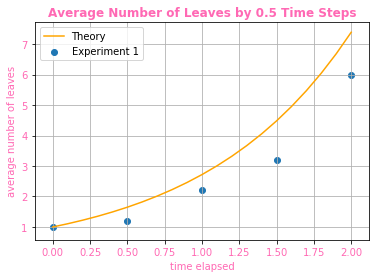

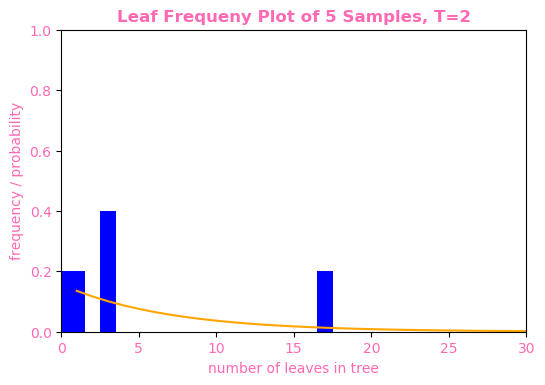

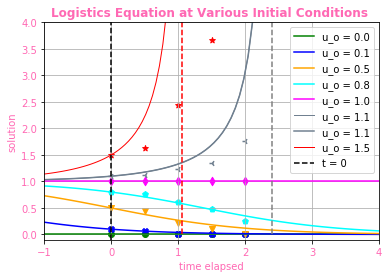

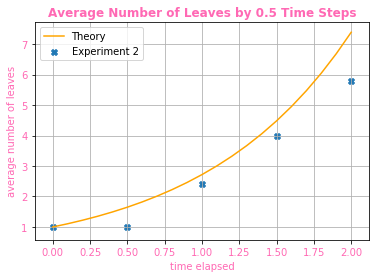

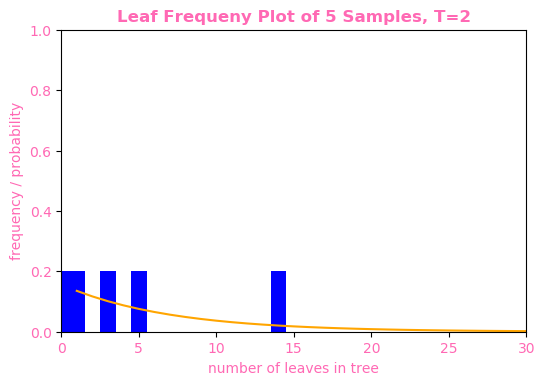

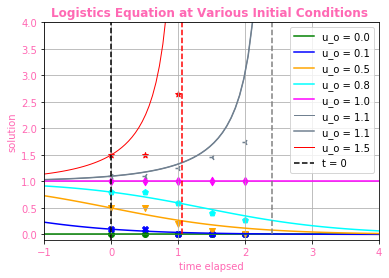

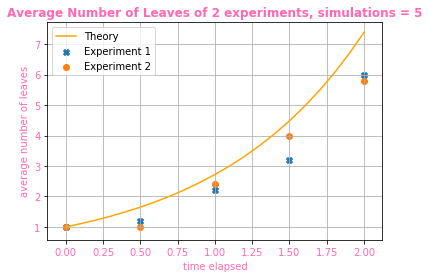

In [194]:
# Main

print('total_max', theory_points, 't_width', t_width) # prints the parpameter just to visualize code started
pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf") # to create a separate pdf of the tree plots 
solution_data = np.array([]) # to make ultimate desired ploted results in theory_plot_comp()
results_shown = np.array([]) # to make ultimate desired ploted results in theory_plot_comp()
for i in range (comparison_points):
    initiate_arrays()
    for z in range (num_iterations):
        initialize() # Setting Initial Parameters
        start_time = time() # # Record when computation will start, as an extra safety to prevent infinite while loop 
        base_case() # initialize base case
        while ((time() - start_time) < t_safe):
            iterative_loop() #iterates until tree finishes of the run time excededs that of the inputed t_safety per generation creation 
            if int(lev[-1]) == 0: # Tree is totally finished 
                break
        buckets() # counts nodes per and accumulation of bins
        count_leaves() # New: need to add nodes non_last_gen_ended vs last_gen_ ended for rxploding trees
        plots() # Run if  will be generating plots, otherwise code above will only result in numerically obtained values 
        evolution_tree(z) # Tree visual, pasing the simulation number value.
        #yule_process_ind(z) # Plot per each iteration, yet want the average
    yule_process(i) 
    probability_plot()
    theory_plot()
pdf.close()    
yule_process_comp()
#theory_plot_comp() #fixing plots
      


